# ROC Curves for ParticleNet TXbb

Author: Raghav Kansal

In [1]:
import os
from pathlib import Path
import pandas as pd
import uproot
import numpy as np
import pickle
import vector
from sklearn.metrics import roc_curve, auc
import scipy

from HH4b import utils, plotting

Import libraries

In [2]:
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

In [3]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [4]:
MAIN_DIR = Path("../../../")
plot_dir = MAIN_DIR / "plots/PNet/24Apr17"
plot_dir.mkdir(parents=True, exist_ok=True)

In [6]:
year = "2022EE"
samples = {
    "hh4b": [
        "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
    ],
    "qcd": [
        "QCD_HT-1000to1200",
        "QCD_HT-100to200",
        "QCD_HT-1200to1500",
        "QCD_HT-1500to2000",
        "QCD_HT-2000",
        "QCD_HT-200to400",
        "QCD_HT-400to600",
        "QCD_HT-600to800",
        "QCD_HT-800to1000",
    ],
    "ttbar": [
        "TTto2L2Nu",
        "TTto4Q",
        "TTtoLNu2Q",
    ],
}

dirs = {MAIN_DIR / "../data/skimmer/24Mar31_v12_signal": samples}

# columns to load
load_columns = [
    ("weight", 1),
    ("bbFatJetPNetXbb", 2),
]
# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")

filters = [
    [
        ("('bbFatJetPt', '0')", ">=", 300),
        ("('bbFatJetPt', '1')", ">=", 300),
    ],
]

events_dict = {}
for input_dir, samples in dirs.items():
    print(samples)
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(
            input_dir, samples, year, filters=filters, columns=columns, variations=False, reorder_legacy_txbb=False,
        ),
    }

cutflow = pd.DataFrame(index=list(samples.keys()))
utils.add_to_cutflow(events_dict, "Preselection", "finalWeight", cutflow)
cutflow

{'hh4b': ['GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV'], 'qcd': ['QCD_HT-1000to1200', 'QCD_HT-100to200', 'QCD_HT-1200to1500', 'QCD_HT-1500to2000', 'QCD_HT-2000', 'QCD_HT-200to400', 'QCD_HT-400to600', 'QCD_HT-600to800', 'QCD_HT-800to1000'], 'ttbar': ['TTto2L2Nu', 'TTto4Q', 'TTtoLNu2Q']}
Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 100488 entries
Loaded QCD_HT-2000                                       : 2643050 entries
Loaded QCD_HT-400to600                                   : 202 entries
Loaded QCD_HT-800to1000                                  : 164768 entries
Loaded QCD_HT-600to800                                   : 27278 entries
Loaded QCD_HT-1500to2000                                 : 1281636 entries
Loaded QCD_HT-200to400                                   : 3 entries
Loaded QCD_HT-1000to1200                                 : 433371 entries
Loaded QCD_HT-1200to1500                                 : 771285 entries
Loaded QCD_HT-100to200                

,Preselection
hh4b,4.104823
qcd,765148.220277
ttbar,29138.457161


In [7]:
jet = 1  # second jet
sig_key = "hh4b"
bg_keys = ["qcd", "ttbar"]
# bg_skip = 1

y_true = np.concatenate(
    [
        np.ones(len(events_dict["hh4b"])),
        np.zeros(np.sum(len(events_dict[bg_key]) for bg_key in bg_keys)),
    ]
)
# print(y_true[np.sum(sig_cut):])

weights = np.concatenate(
    [events_dict[sig_key]["finalWeight"]]
    + [events_dict[bg_key]["finalWeight"] for bg_key in bg_keys],
)

scores = np.concatenate(
    [events_dict[sig_key]["bbFatJetPNetXbb"][jet]]
    + [events_dict[bg_key]["bbFatJetPNetXbb"][jet] for bg_key in bg_keys],
)

/var/folders/np/80b736zs2753ch8xq6lq33d80000gq/T/ipykernel_14969/4206862019.py:9: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.zeros(np.sum(len(events_dict[bg_key]) for bg_key in bg_keys)),


In [8]:
fpr, tpr, thresholds = roc_curve(y_true, scores, sample_weight=weights)
roc = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds}

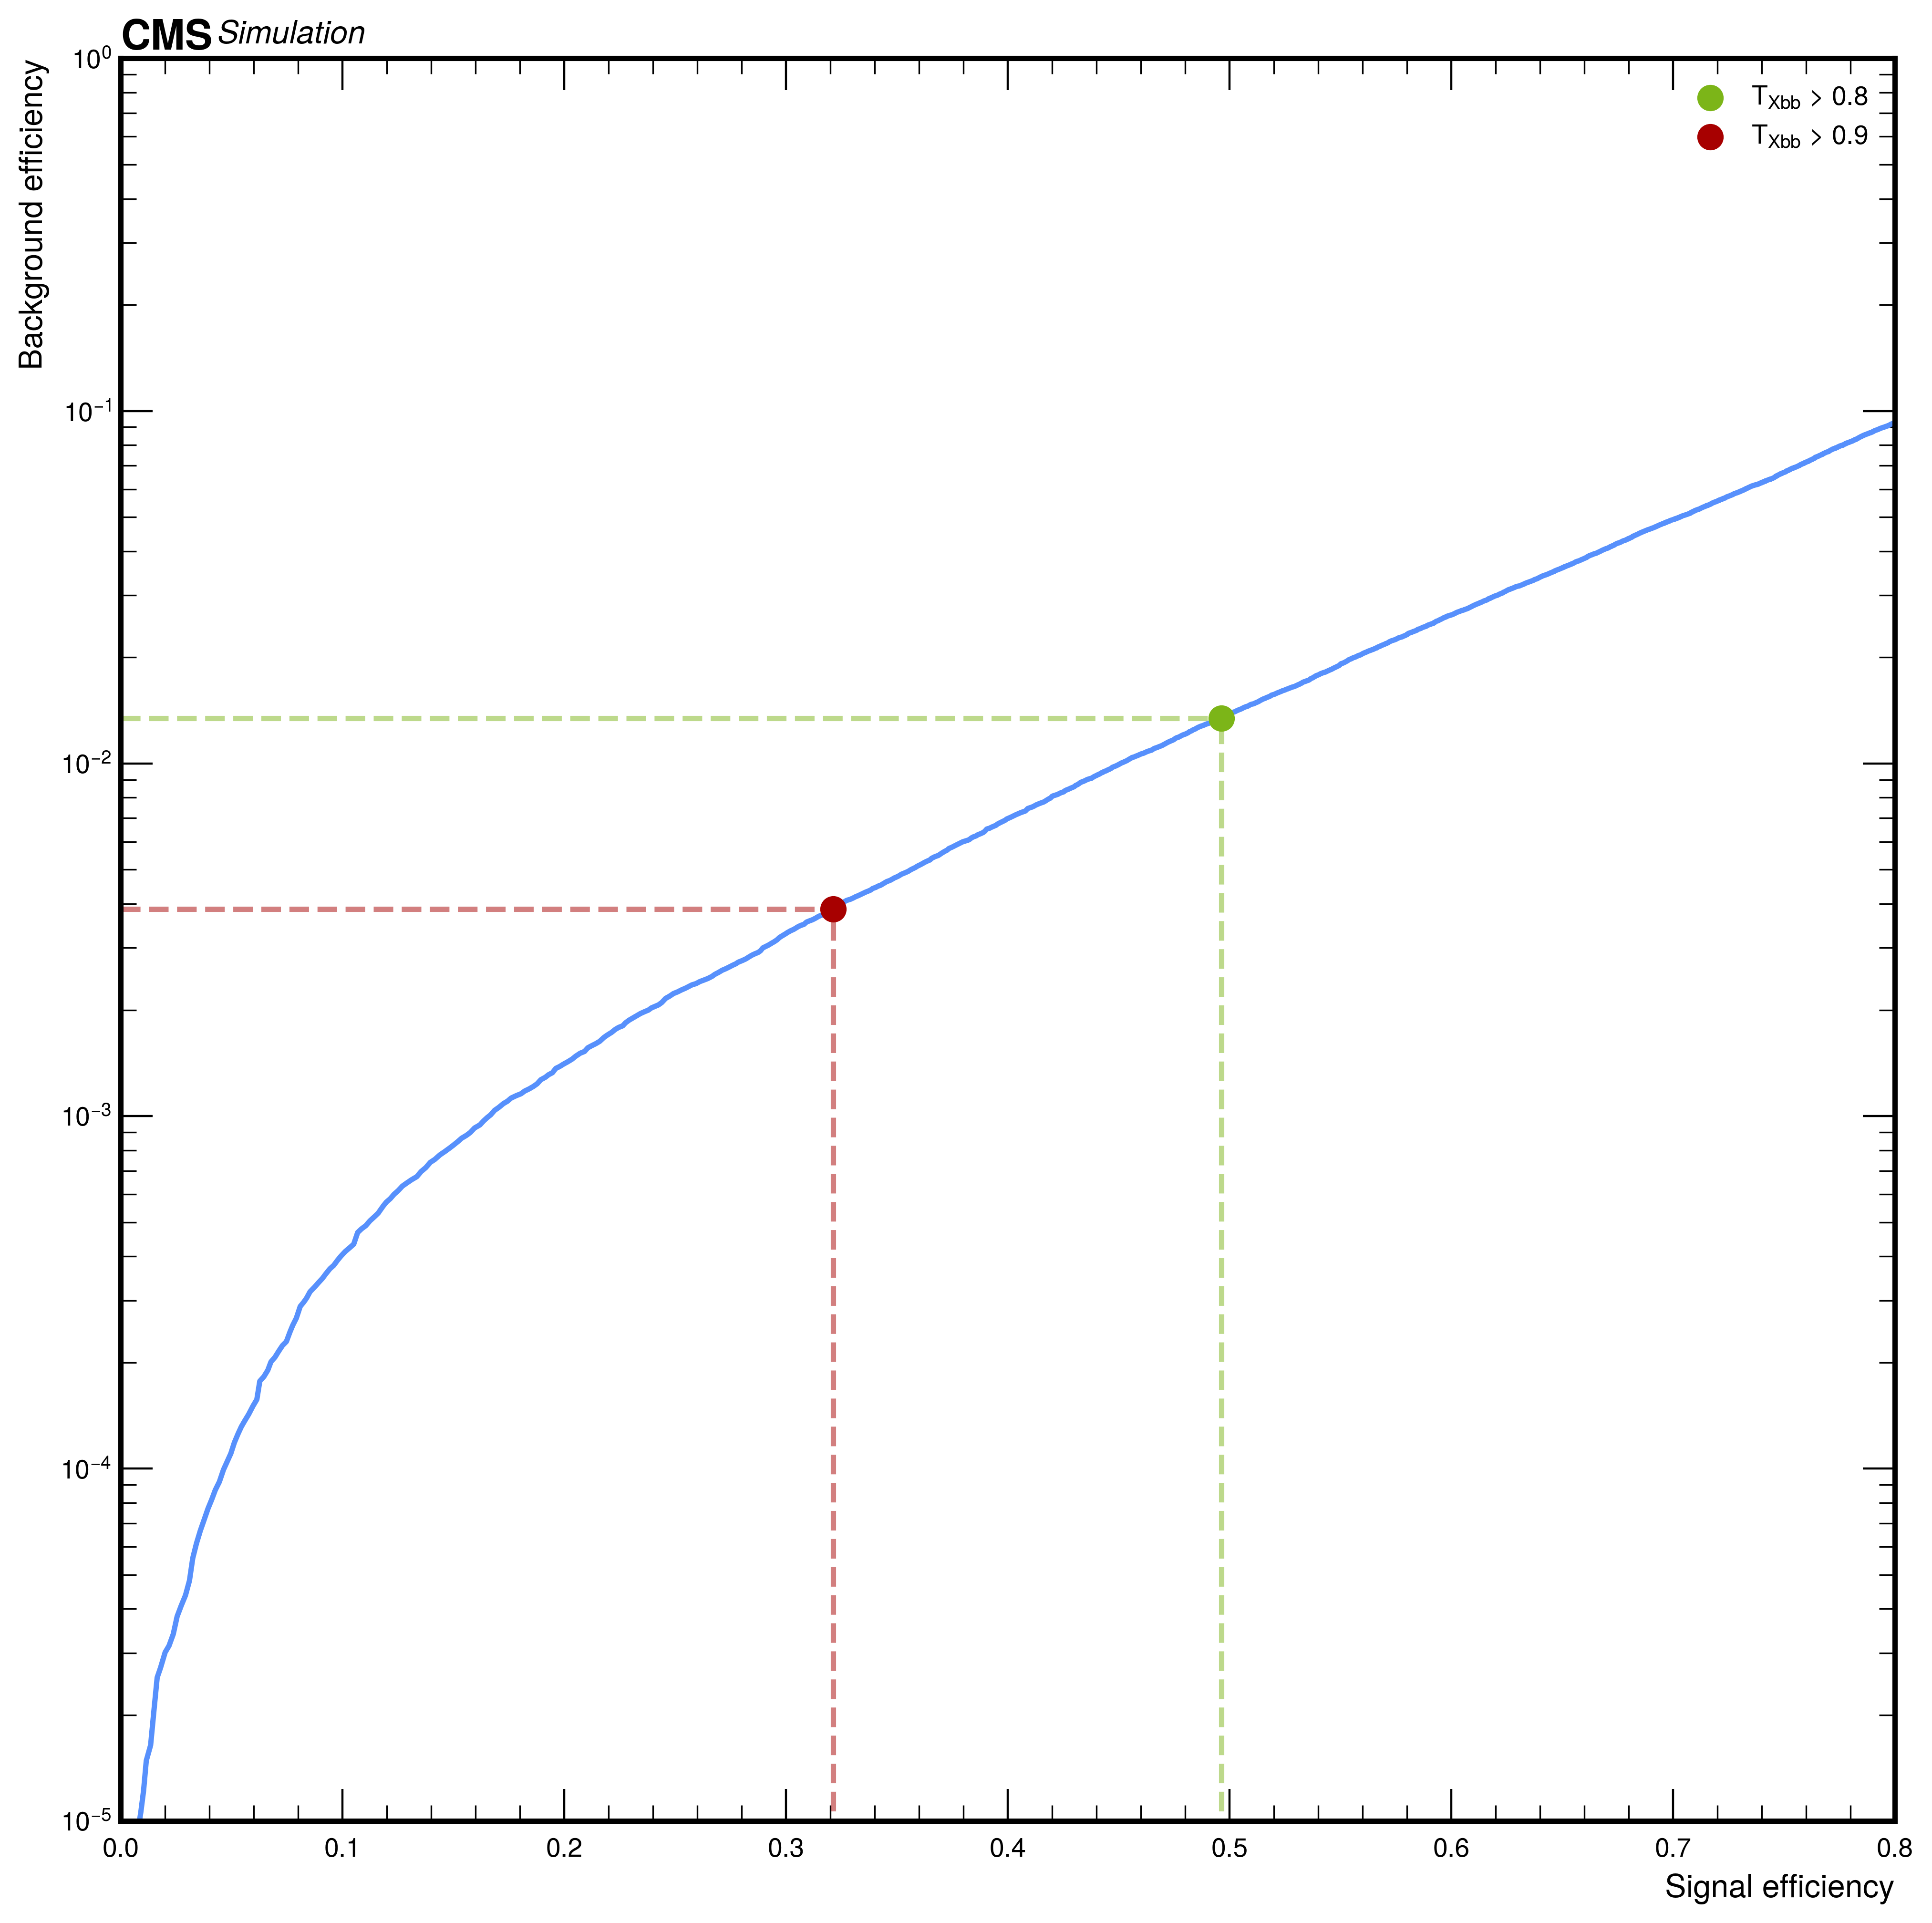

In [9]:
plotting.ROCCurve(
    roc,
    xlim=[0, 0.8],
    ylim=[1e-5, 1],
    thresholds=[0.8, 0.9],
    show=True,
    plot_dir=plot_dir,
    name=f"bbFatJet{jet+1}ROC",
)

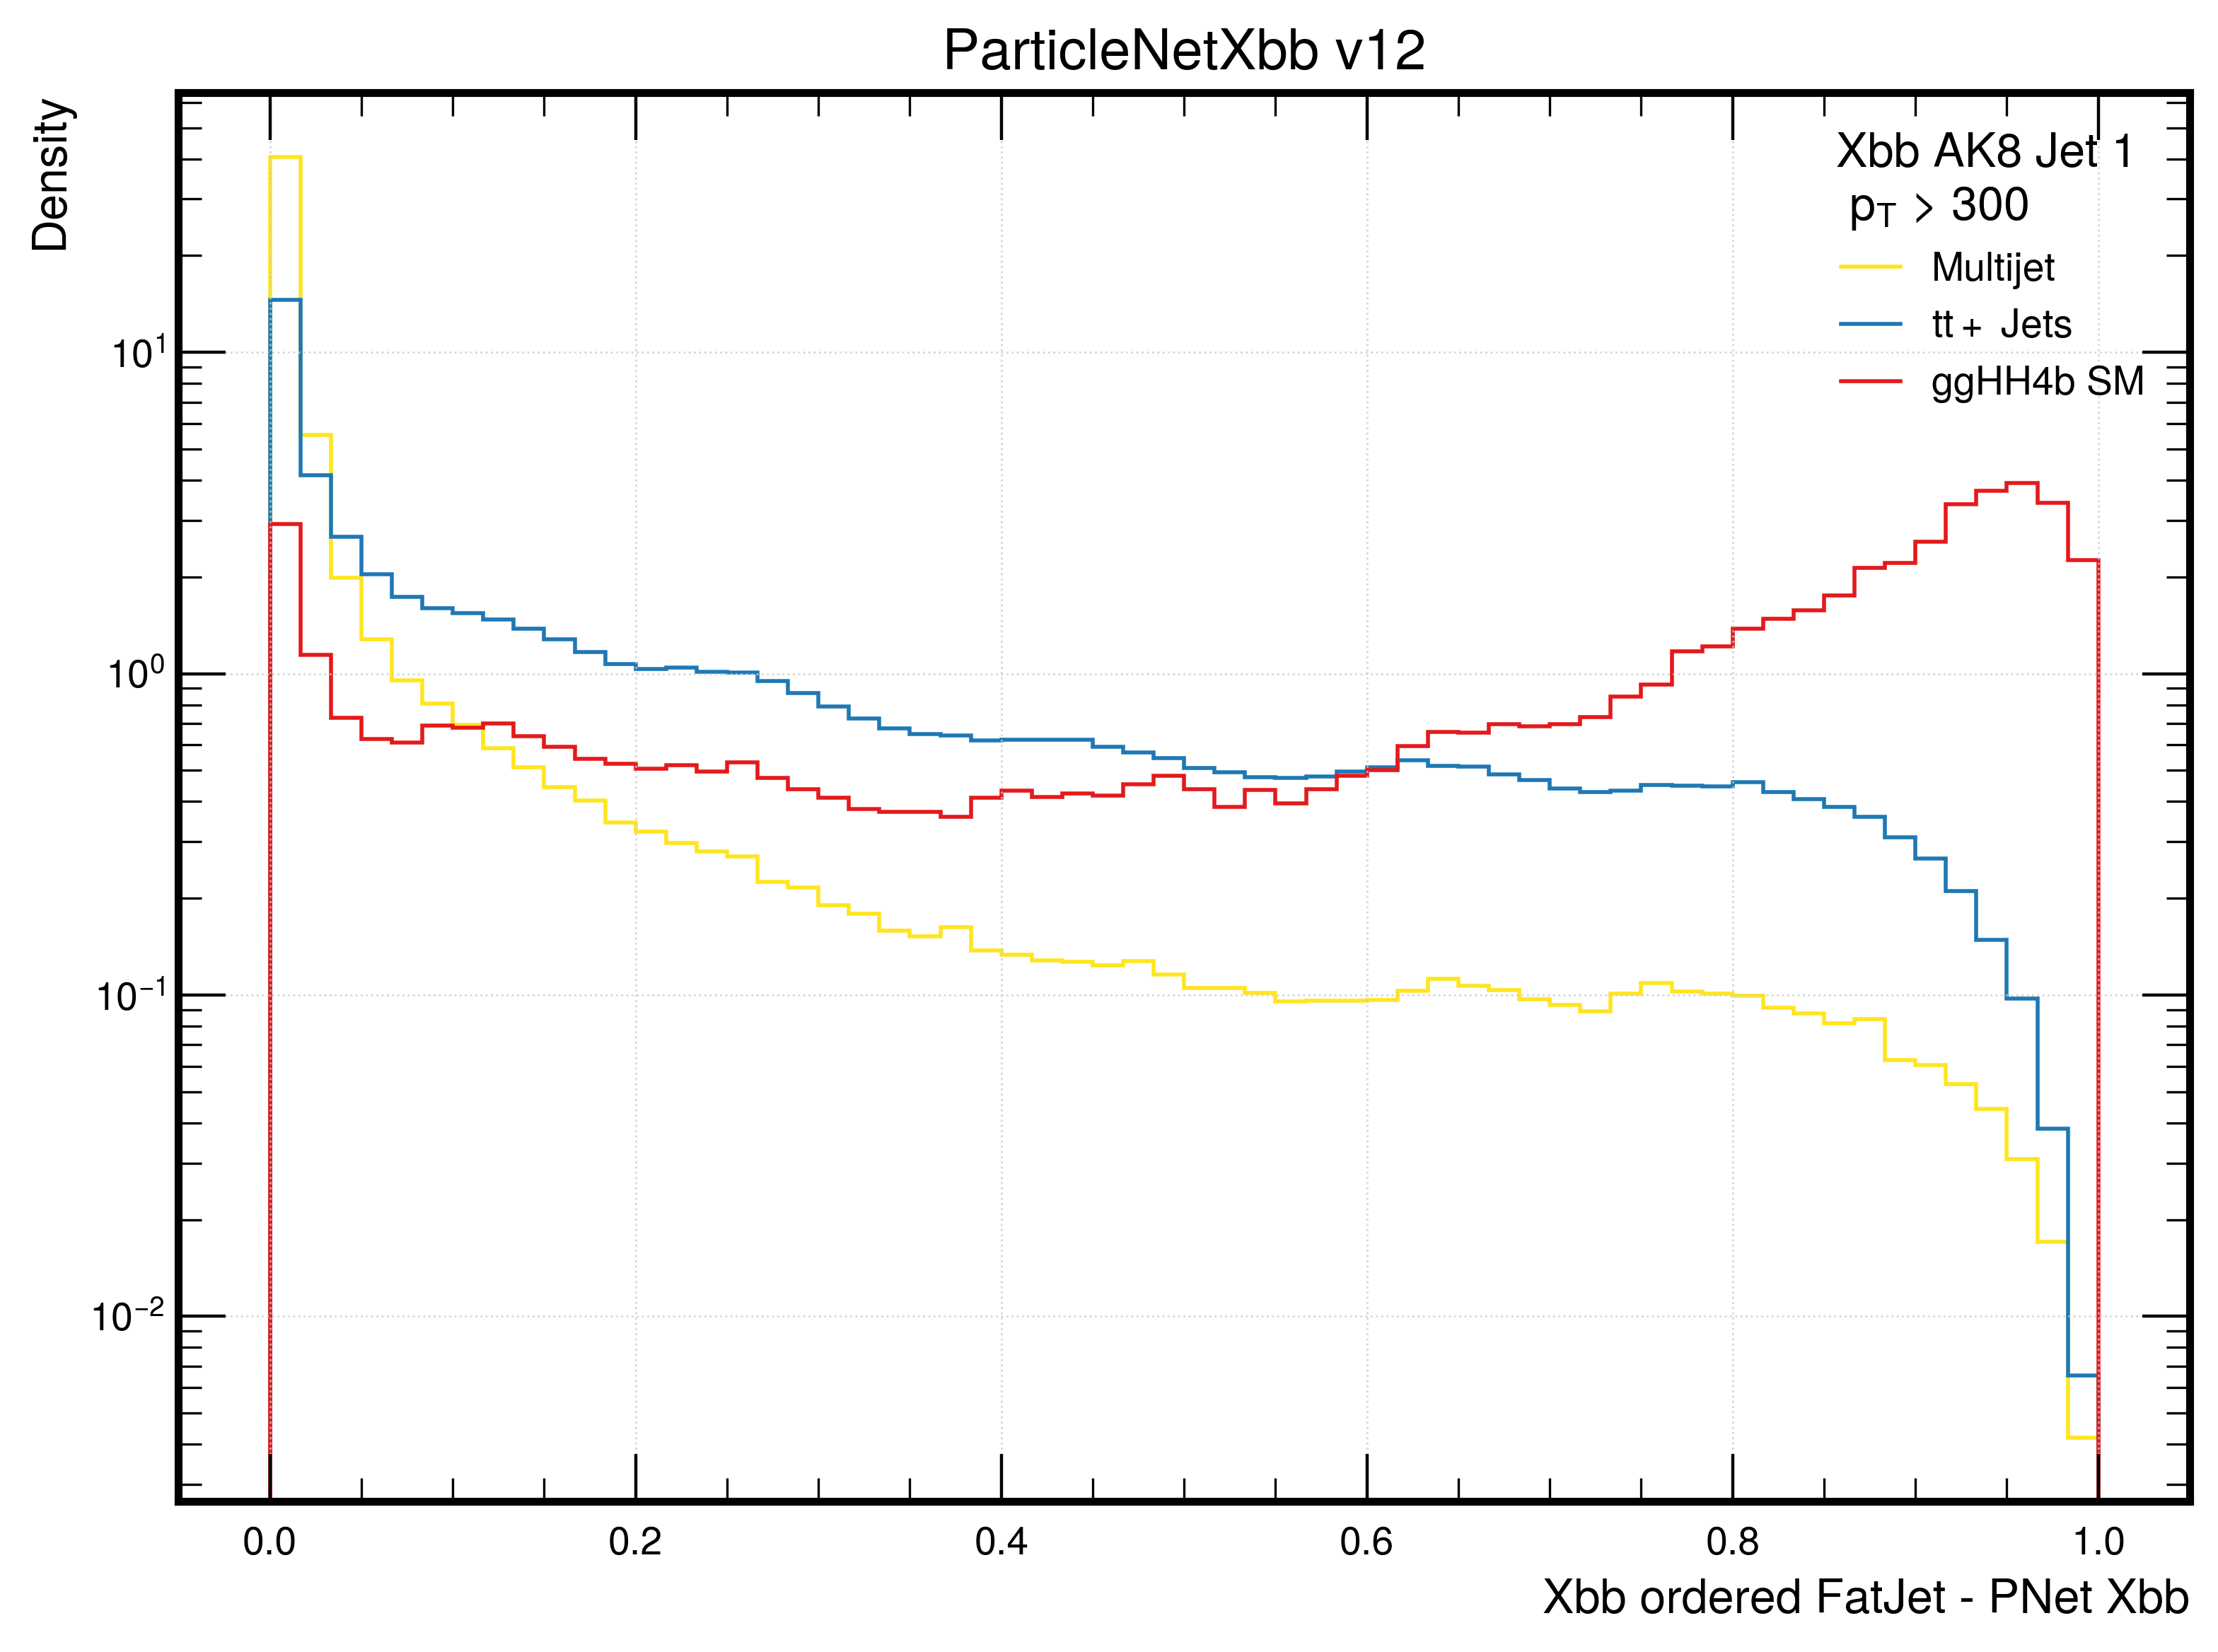

In [28]:
import hist

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

xbb_axis = hist.axis.Regular(60, 0, 1, name="xbb", label="Xbb ordered FatJet - PNet Xbb")
sample_axis = hist.axis.StrCategory([], name="cat", growth=True)
h = hist.Hist(xbb_axis, sample_axis)

for key in ["qcd", "ttbar", "hh4b"]:
    h.fill(events_dict[key]["bbFatJetPNetXbb"][1], key, weight=events_dict[key]["finalWeight"].to_numpy())

labels = {
    "qcd": "Multijet",
    "ttbar": r"$tt+$ Jets",
    "hh4b": "ggHH4b SM",
}
bkg_colors = {**plotting.color_by_sample}

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for key in ["qcd", "ttbar", "hh4b"]:
    hep.histplot(
            h[{"cat": key}],
            ax=ax,
            label=f"{labels[key]}",
            density=True,
            color=bkg_colors[key],
        )
    ax.legend(title=f"Xbb AK8 Jet 1 \n " + r"p$_T$ > 300")
    ax.set_ylabel("Density")
    ax.set_title("ParticleNetXbb v12")
    ax.set_yscale("log")
    ax.xaxis.grid(True, which="major")
    ax.yaxis.grid(True, which="major")
fig.tight_layout()
fig.savefig("PNetXbb_2022EE_v12.png")
fig.savefig("PNetXbb_2022EE_v12.pdf")
    
